# Lesson 6 - Multi-LoRA

In this lesson, we'll see how to efficiently serve dozens of fine-tuned models together in a single deployment without sacrificing latency.

### Import required packages

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn.functional as F

from tqdm import tqdm

### Let's create a new model

We will start with creating an extension to the model from lesson 5. It has a custom helper function for computing the LoRA layer step with multiple LoRAs per batch.

In [ ]:
# hidden_size = 10
# set this so low to ensure we are not 
# compute-bound by the linear layer
# this is only an issue when running on CPU, 
# for GPUs we can set this much
# higher and still avoid being compute bound

class AbstractMultiLoraModel(torch.nn.Module):
    def __init__(self, n_vocab=10, hidden_size=10):
        super().__init__()

        self.embedding = torch.nn.Embedding(num_embeddings=n_vocab, embedding_dim=hidden_size)
        self.linear = torch.nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.lm_head = torch.nn.Linear(in_features=hidden_size, out_features=n_vocab)
    
    def linear_lora(
            self,
            x: torch.Tensor,                # (batch_size, seq_len, in_features)
            loras_a: torch.Tensor,          # (num_loras, in_features, rank)
            loras_b: torch.Tensor,          # (num_loras, rank, out_features)
            lora_indices: torch.LongTensor  # (batch_size,)
        ) -> torch.Tensor:
        # y[i] = x[i] @ loras_a[lora_idx] @ loras_b[lora_idx]
        raise NotImplementedError()

    def forward(self, input_ids, loras_a, loras_b, lora_indices):
        x = self.embedding(input_ids)
        x = self.linear_lora(x=x, loras_a=loras_a, loras_b=loras_b, lora_indices=lora_indices)
        x = self.lm_head(x)

        return x

### Using a loop

Our first attempt to infer across multiple LoRAs will be straightforward: just loop over every row in the batch and apply the correct LoRA using an index mapping: `batch_index --> lora_index`.

In [3]:
class LoopMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
            self,
            x: torch.Tensor,                # (batch_size, seq_len, in_features)
            loras_a: torch.Tensor,          # (num_loras, in_features, lora_rank)
            loras_b: torch.Tensor,          # (num_loras, lora_rank, out_features)
            lora_indices: torch.LongTensor  # (batch_size,)
        ) -> torch.Tensor:
        
        y = self.linear(x)
        
        for batch_index, lora_idx in enumerate(lora_indices.numpy()):
            lora_a = loras_a[lora_idx]
            lora_b = loras_b[lora_idx]
            y[batch_index] += y[batch_index] @ lora_a @ lora_b
        
        return y

In [4]:
# toy example of a detokenizer. The vocabulary consists of only 10 words (different colors)
detokenizer = [
    "red",
    "orange",
    "yellow",
    "green",
    "blue",
    "indigo",
    "violet",
    "magenta",
    "marigold",
    "chartreuse",
]

In [5]:
# dummy inputs
input_ids = torch.LongTensor([[0,1,2,3,4,5,6,7]])

In [6]:
# assign a seed for random number generation
torch.manual_seed(42)

In [7]:
def generate_token(model, **kwargs):
    with torch.no_grad():
        logits = model(**kwargs)
    
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)

    return [detokenizer[token_id] for token_id in next_token_ids]

In [8]:
model = LoopMultiLoraModel()

### Let's try it!

We will try this over a few random LoRAs using a fixed tensor of input_ids. If our multi-LoRA generation process is working as designed, we should see a variety of different outputs generated as we randomly iterate over the LoRAs.

In [12]:
# constants
bs = 1          # Batch size
num_loras = 64  # Number of LoRA adapters
h = 10          # Hidden size
r = 2           # Rank

# create contiguous blocks for num_loras random LoRA weights
loras_a = torch.randn(num_loras, h, r)
loras_b = torch.randn(num_loras, r, h)

for i in range(10):
    # randomize the LoRAs each iteration
    lora_indices = torch.randint(num_loras, (bs,), dtype=torch.long)
    next_token = generate_token(
        model=model,
        input_ids=input_ids,
        loras_a=loras_a,
        loras_b=loras_b,
        lora_indices=lora_indices
    )
    print(next_token)

['red']
['violet']
['violet']
['blue']
['indigo']
['orange']
['chartreuse']
['red']
['indigo']
['red']


### Let's benchmark our multi-LoRA system!

We will measure the average latency to generate a single token as the batch size increases and each element within the batch can have a different LoRA adapter (chosen randomly).

In [13]:
# constants
seq_len = 8
vocab_size = 10
nsamples = 500
max_batch_size = 64

def benchmark(model):
    avg_latencies = []
    
    for bs in range(1, max_batch_size+1):
        latencies = []
        # Collect latencies for nsamples and compute average
        for _ in range(nsamples):
            # randomize the inputs and LoRA indices
            input_ids = torch.randint(vocab_size, (bs, seq_len), dtype=torch.long)
            lora_indices = torch.randint(num_loras, (bs,), dtype=torch.long)

            # measure the end-to-end latency for generating a single token
            t0 = time.time()
            next_token = generate_token(
                model=model,
                input_ids=input_ids,
                loras_a=loras_a,
                loras_b=loras_b,
                lora_indices=lora_indices
            )
            latencies.append(time.time() - t0)
        
        # average the latency across all the samples
        latency_s = sum(latencies)/nsamples
        avg_latencies.append(latency_s)
        print(f"Batch size: {bs} :: Avergae latency: {latency_s}")
    
    return avg_latencies


In [14]:
avg_latencies_loop = benchmark(model=model)

Batch size: 1 :: Avergae latency: 7.744932174682617e-05
Batch size: 2 :: Avergae latency: 5.34367561340332e-05
Batch size: 3 :: Avergae latency: 6.0360431671142575e-05
Batch size: 4 :: Avergae latency: 6.842803955078125e-05
Batch size: 5 :: Avergae latency: 7.538032531738281e-05
Batch size: 6 :: Avergae latency: 8.864879608154297e-05
Batch size: 7 :: Avergae latency: 9.055566787719726e-05
Batch size: 8 :: Avergae latency: 0.00011149120330810547
Batch size: 9 :: Avergae latency: 0.00010928249359130859
Batch size: 10 :: Avergae latency: 0.00011791038513183594
Batch size: 11 :: Avergae latency: 0.00013134479522705078
Batch size: 12 :: Avergae latency: 0.0001280808448791504
Batch size: 13 :: Avergae latency: 0.00013814306259155273
Batch size: 14 :: Avergae latency: 0.00015583086013793945
Batch size: 15 :: Avergae latency: 0.00016645145416259766
Batch size: 16 :: Avergae latency: 0.00016998910903930664
Batch size: 17 :: Avergae latency: 0.00018472671508789061
Batch size: 18 :: Avergae laten

### Let's visualize it!

**Note**: Your plot may vary slightly from the one shown in the video, yet it will exhibit a similar pattern.

In [16]:
!mkdir ./output

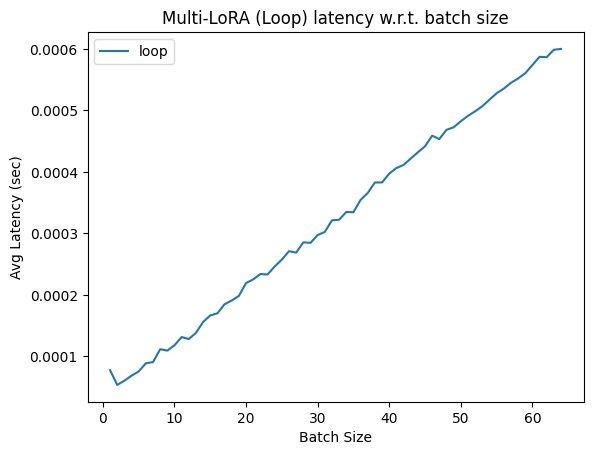

In [18]:
x = list(range(1, max_batch_size+1))
plt.plot(x, avg_latencies_loop, label="loop")
plt.xlabel("Batch Size")
plt.ylabel("Avg Latency (sec)")
plt.title("Multi-LoRA (Loop) latency w.r.t. batch size")
plt.legend()
plt.savefig("./output/loop_multi_lora_latency.png")
plt.show()

### Let's vectorize the LoRA computation

We will vectorize the LoRA computation by:

1. Gather the LoRA weight for each batch into a single tensor using `torch.index_select`.
2. Apply LoRA computation once for the entire input tensor.

In [22]:
class GatheredMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
            self,
            x: torch.Tensor,                      # (batch_size, seq_len, in_features)
            loras_a: torch.Tensor,                # (num_loras, in_features, lora_rank)
            loras_b: torch.Tensor,                # (num_loras. lora_rank, out_features)
            lora_indices: torch.LongTensor        # (batch_size,)
    ) -> torch.Tensor:          
        y = self.linear(x)

        # gather LoRA weights into a tensor and apply
        lora_a = torch.index_select(loras_a, dim=0, index=lora_indices) # (batch_size, in_features, lora_rank)
        lora_b = torch.index_select(loras_b, dim=0, index=lora_indices) # (batch_size, lora_rank, out_features)

        y += x @ lora_a @ lora_b

        return y

In [23]:
model = GatheredMultiLoraModel()

In [24]:
avg_latencies_gathered = benchmark(model=model)

Batch size: 1 :: Avergae latency: 0.00010318326950073242
Batch size: 2 :: Avergae latency: 9.309196472167969e-05
Batch size: 3 :: Avergae latency: 5.585050582885742e-05
Batch size: 4 :: Avergae latency: 6.0897350311279296e-05
Batch size: 5 :: Avergae latency: 7.913446426391601e-05
Batch size: 6 :: Avergae latency: 7.99117088317871e-05
Batch size: 7 :: Avergae latency: 8.704328536987305e-05
Batch size: 8 :: Avergae latency: 6.149196624755859e-05
Batch size: 9 :: Avergae latency: 7.39893913269043e-05
Batch size: 10 :: Avergae latency: 8.330821990966797e-05
Batch size: 11 :: Avergae latency: 6.1920166015625e-05
Batch size: 12 :: Avergae latency: 8.335685729980469e-05
Batch size: 13 :: Avergae latency: 7.505130767822266e-05
Batch size: 14 :: Avergae latency: 6.79926872253418e-05
Batch size: 15 :: Avergae latency: 8.286619186401367e-05
Batch size: 16 :: Avergae latency: 6.829261779785156e-05
Batch size: 17 :: Avergae latency: 8.790922164916993e-05
Batch size: 18 :: Avergae latency: 7.995700

### Let's visualize it!

**Note**: Your plot may vary slightly from the one shown in the video, yet it will exhibit a similar pattern.

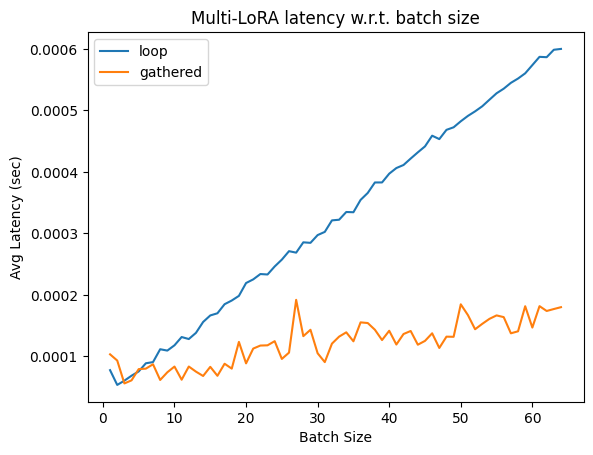

In [25]:
x = list(range(1, max_batch_size+1))

plt.plot(x, avg_latencies_loop, label="loop")
plt.plot(x, avg_latencies_gathered, label="gathered")

plt.xlabel("Batch Size")
plt.ylabel("Avg Latency (sec)")
plt.title("Multi-LoRA latency w.r.t. batch size")
plt.legend()

plt.savefig("./output/multi_lora_latency.png")

plt.show()